In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv('Assignment2 (1).data', sep='\t')

## Task 1

#### Part 1

In [3]:
y2 = pd.DataFrame({"x":range(226), "y":data.StockPrice})
yy = np.array(y2.y)
xx = np.expand_dims(y2.x, 1).reshape(-1, 1)

In [4]:
# estimate the value of the beta vector assuming that X is made of independent features.
def estimateBeta(X, y):
    numerator = np.matmul(np.transpose(X), y)
    denom = np.matmul(np.transpose(X), X)
    denom_inv = np.linalg.inv(denom)
    beta = np.matmul(denom_inv, numerator)
    return beta

# create a helper that would estimate yhat from X and beta.
def predict(beta, X):
    # reshape the input to a matrix, if it is appearing like an 1d array.
    if len(X.shape) != 2:
        X = np.expand_dims(X,1)
    # convert the beta list in to an array.
    beta = np.array(beta)
    # perform estimation of yhat.
    return np.matmul(X, beta)

# compute the sum of squared error between y and yhat.
def SSE(y, yhat):
    return np.sum((y-yhat)**2)

In [5]:
numerator = np.matmul(np.transpose(xx), yy)
denom = np.matmul(np.transpose(xx), xx)
denom_inv = np.linalg.inv(denom)

beta = np.matmul(denom_inv, numerator)
yhat1 = predict(beta, y2.x)
sse = SSE(yy,yhat1)

print("\nOLS closed form solution:")
print("Beta = ", beta[0])
print("SSE = ", sse)


OLS closed form solution:
Beta =  0.11899412514961837
SSE =  3850.335433080234


Text(0.5, 1.0, 'OLS closed form solution')

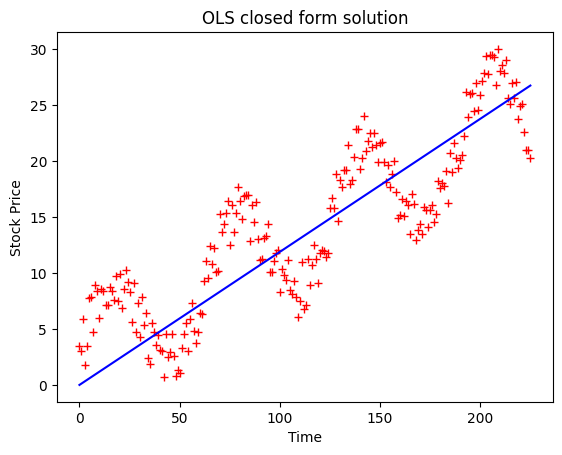

In [6]:
plt.plot(y2.x, y2.y, 'r+')
plt.plot(y2.x, yhat1, 'b-')
plt.ylabel('Stock Price')
plt.xlabel('Time')
plt.title('OLS closed form solution')

#### Part 2

Theta (in deg) for min SSE: 5
Corresponding slope for min SSE: 0.08748866352592401
Min SSE: 7644.253463286041


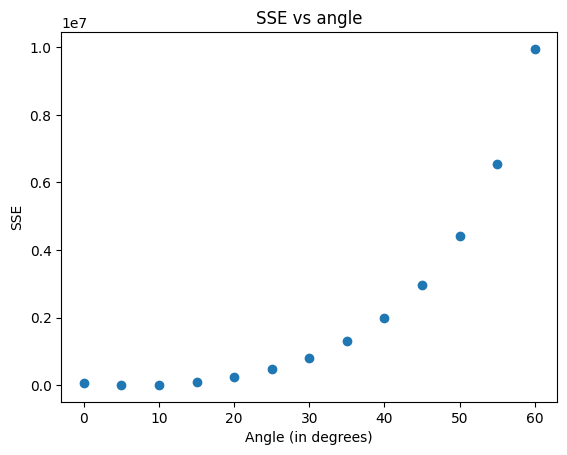

In [7]:
angle = np.arange(0,61,5)
sse = []

for i in range(len(angle)):
    sse.append(SSE((xx*np.tan(np.radians(angle[i]))), np.expand_dims(yy, 1)))

plt.scatter(angle, sse)
plt.title("SSE vs angle")
plt.xlabel("Angle (in degrees)")
plt.ylabel("SSE")

angle_min = 5*np.argmin(sse, 0)

print("Theta (in deg) for min SSE:", angle_min)
print("Corresponding slope for min SSE:", np.tan(np.radians(angle_min)))
print("Min SSE:", np.min(sse))

#### Part 3

In [8]:
model = LinearRegression()
model.fit(xx, yy)
yhat3 = model.predict(xx)
loss = SSE(yy, yhat3)

beta3 = model.coef_[0]
bias = model.intercept_

print("\nLinearRegression solution:")
print("Intercept =", bias, "\nBeta =", beta3)
print("SSE =", loss)


LinearRegression solution:
Intercept = 3.1824478577833197 
Beta = 0.09782484893376478
SSE = 3274.298469663405


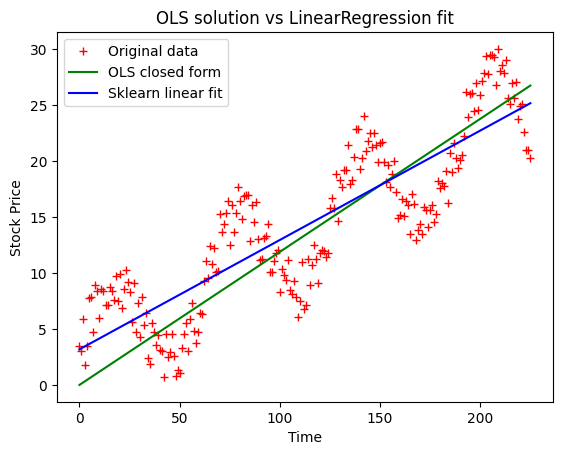

In [9]:
plt.plot(y2.x, y2.y, 'r+', label = "Original data")
plt.plot(y2.x, yhat1, 'g-', label = "OLS closed form")
plt.plot(y2.x, yhat3, 'b-', label = "Sklearn linear fit")
plt.ylabel('Stock Price')
plt.xlabel('Time')
plt.title('OLS solution vs LinearRegression fit')
plt.legend()

#### Part 4
The results that we get in the above parts are as follows:
1. Beta: 0.11899412514961837
2. Beta: 0.08748866352592401
3. Beta: 0.09782484893376478

The reason for thier differences is as follows:
1. We considered the intercept to be 0 necessarily so we could optimise only on the slope.
2. We iterated over a step size of 5 degrees so missed out greatly on the minute details for optimisation.
3. The sklearn library gave the best fit line with an intercept as well so overall fit was much better.

## Task 2

The data suggest it is better to use a mathematical model which is a combination of linear and a periodic trigonometric function like sin to fit the data really well.

Instead of using $x$ in integer scale, we shall use the floating point scale as $x_1 \leftarrow \beta_0 * x$

Likewise, let's create a new data dimension to capture the periodicity as $x_2 \leftarrow sin(x_1)$

Based on the expanded feature space, let's model $\hat{y} = m_1 x_1 + m_2 x_2 + c$.


In [10]:
x1 = y2.x*beta3
x2 = np.sin(x1)

y21 = pd.DataFrame({"bias":np.ones(226), "x1":x1, "x2":x2, "y":data.StockPrice})

#### Random split for interpolation

In [11]:
X_train_val1, X_test1, y_train_val1, y_test1 = train_test_split(y21.iloc[:,:-1], y21.iloc[:,-1], test_size=0.2, random_state=42)
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train_val1, y_train_val1, test_size=0.125, random_state=42)

X_train1 = X_train1.sort_index()
y_train1 = y_train1.sort_index()

X_val1 = X_val1.sort_index()
y_val1 = y_val1.sort_index()

X_test1 = X_test1.sort_index()
y_test1 = y_test1.sort_index()

In [12]:
xx_train1 = np.array(X_train1[['bias', 'x1', 'x2']])
yy_train1 = np.array(y_train1)

beta4 = estimateBeta(xx_train1, yy_train1)

yhat_train1 = predict(beta4, xx_train1)
loss_train1 = SSE(yy_train1, yhat_train1)

print("\nInterpolation part")
print("\nTraining set loss after feature engineering:")
print("Beta =", beta4)
print("SSE =", loss_train1)


Interpolation part

Training set loss after feature engineering:
Beta = [2.75274807 1.00224156 4.80097777]
SSE = 510.7264270732065


Text(0.5, 0, 'Time')

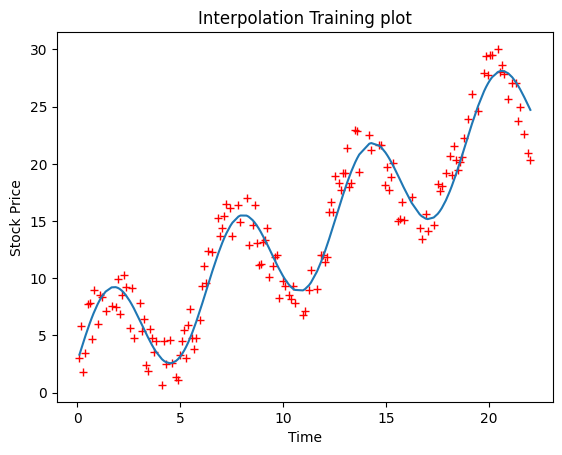

In [13]:
plt.plot(X_train1.x1, y_train1, 'r+')
plt.plot(X_train1.x1, yhat_train1)
plt.title("Interpolation Training plot")
plt.ylabel('Stock Price')
plt.xlabel('Time')

In [14]:
xx_val1 = np.array(X_val1[['bias', 'x1', 'x2']])
yy_val1 = np.array(y_val1)

yhat_val1 = predict(beta4, xx_val1)

loss_val1 = SSE(yy_val1, yhat_val1)
print("\nValidation set loss after feature engineering:")
print("SSE =", loss_val1)


Validation set loss after feature engineering:
SSE = 49.93719081801027


In [15]:
xx_test1 = np.array(X_test1[['bias', 'x1', 'x2']])
yy_test1 = np.array(y_test1)

yhat_test1 = predict(beta4, xx_test1)

loss_test1 = SSE(yy_test1, yhat_test1)
print("\nTest set loss after feature engineering:")
print("SSE =", loss_test1)


Test set loss after feature engineering:
SSE = 140.82320070197494


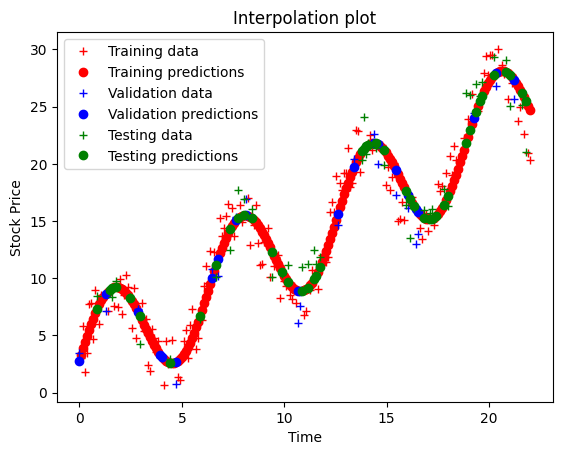

In [16]:
plt.plot(X_train1.x1, y_train1, 'r+', label = 'Training data')
plt.plot(X_train1.x1, yhat_train1, 'ro', label = 'Training predictions')

plt.plot(X_val1.x1, y_val1, 'b+', label = 'Validation data')
plt.plot(X_val1.x1, yhat_val1, 'bo', label = 'Validation predictions')

plt.plot(X_test1.x1, y_test1, 'g+', label = 'Testing data')
plt.plot(X_test1.x1, yhat_test1, 'go', label = 'Testing predictions')

plt.title("Interpolation plot")
plt.ylabel('Stock Price')
plt.xlabel('Time')
plt.legend()

In [17]:
print("Total SSE for interpolation (Stock data) =", loss_train1 + loss_val1 + loss_test1)

Total SSE for interpolation (Stock data) = 701.4868185931916


#### Timestamp wise spilt for extrapolation

In [18]:
X_train2 = y21.iloc[:158,:-1]
X_val2 = y21.iloc[158:180,:-1]
X_test2 = y21.iloc[180:,:-1]

y_train2 = y21.iloc[:158,-1]
y_val2 = y21.iloc[158:180,-1]
y_test2 = y21.iloc[180:, -1]

In [19]:
xx_train2 = np.array(X_train2[['bias', 'x1', 'x2']])
yy_train2 = np.array(y_train2)

beta5 = estimateBeta(xx_train2, yy_train2)

yhat_train2 = predict(beta5, xx_train2)
loss_train2 = SSE(yy_train2, yhat_train2)

print("\nExtrapolation part of Stock data:")
print("\nTraining set loss after feature engineering:")
print("Beta =", beta5)
print("SSE =", loss_train2)


Extrapolation part of Stock data:

Training set loss after feature engineering:
Beta = [2.61758278 1.02173157 4.83494605]
SSE = 407.1341097894974


Text(0.5, 0, 'Time')

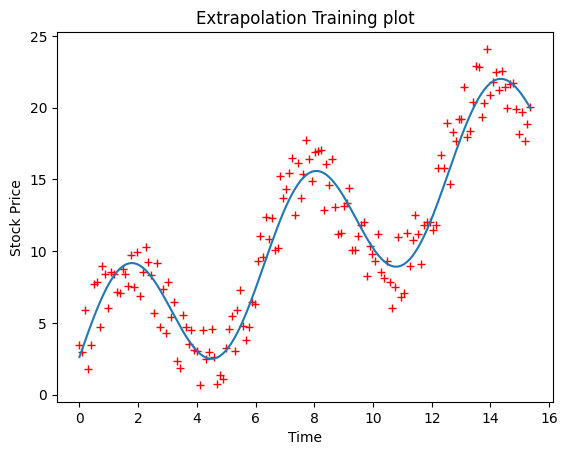

In [20]:
plt.plot(X_train2.x1, y_train2, 'r+')
plt.plot(X_train2.x1, yhat_train2)
plt.title("Extrapolation Training plot")
plt.ylabel('Stock Price')
plt.xlabel('Time')

In [21]:
xx_val2 = np.array(X_val2[['bias', 'x1', 'x2']])
yy_val2 = np.array(y_val2)

yhat_val2 = predict(beta4, xx_val2)

loss_val2 = SSE(yy_val2, yhat_val2)
print("\nValidation set loss after feature engineering:")
print("SSE =", loss_val2)


Validation set loss after feature engineering:
SSE = 88.09374614612932


In [22]:
xx_test2 = np.array(X_test2[['bias', 'x1', 'x2']])
yy_test2 = np.array(y_test2)

yhat_test2 = predict(beta4, xx_test2)

loss_test2 = SSE(yy_test2, yhat_test2)
print("\nTest set loss after feature engineering:")
print("SSE =", loss_test2)


Test set loss after feature engineering:
SSE = 204.91860336556664


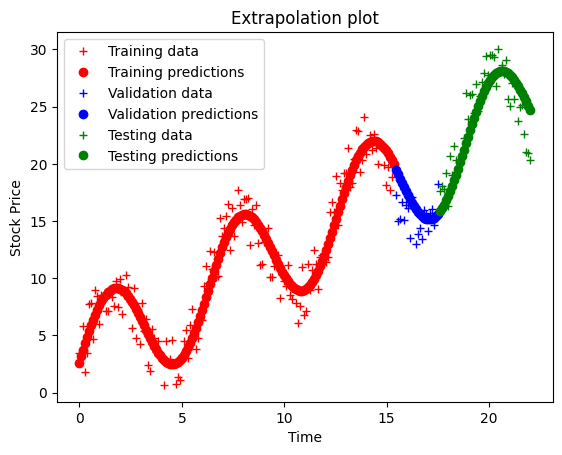

In [23]:
plt.plot(X_train2.x1, y_train2, 'r+', label = 'Training data')
plt.plot(X_train2.x1, yhat_train2, 'ro', label = 'Training predictions')

plt.plot(X_val2.x1, y_val2, 'b+', label = 'Validation data')
plt.plot(X_val2.x1, yhat_val2, 'bo', label = 'Validation predictions')

plt.plot(X_test2.x1, y_test2, 'g+', label = 'Testing data')
plt.plot(X_test2.x1, yhat_test2, 'go', label = 'Testing predictions')

plt.title("Extrapolation plot")
plt.ylabel('Stock Price')
plt.xlabel('Time')
plt.legend()

In [24]:
print("Total SSE for extrapolation (Stock data) =", loss_train2 + loss_val2 + loss_test2)

Total SSE for extrapolation (Stock data) = 700.1464593011933


## Task 3

In [25]:
y1 = pd.DataFrame({"x":range(226), "y":data.SpringPos})
yy = np.array(y1.y)
xx = np.expand_dims(y1.x, 1).reshape(-1, 1)

Text(0, 0.5, 'Spring Position')

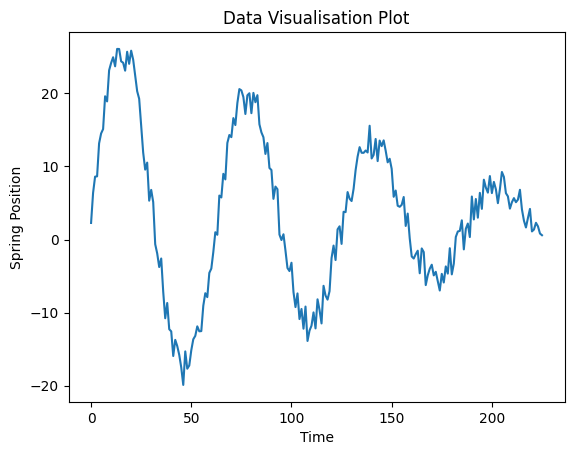

In [26]:
plt.plot(xx,yy)
plt.title('Data Visualisation Plot')
plt.xlabel('Time')
plt.ylabel('Spring Position')

The data suggest it is better to use a mathematical model which is an exponential decay equation: $y(x) = c_0 + c_1e^{-\beta_1 x} * sin(\beta_2 x)$

Now, the above equation can be simplified mathematically and finally get the following equation to model:

$y(x) = c_0 + (c_1 + c_2x)sin(\beta x)$.

Instead of using $x$ in integer scale, we shall use the floating point scale as $x_1 \leftarrow sin(\beta x)$

Likewise, let's create a new data dimension to capture the periodicity as $x_2 \leftarrow x*sin(\beta x)$

Based on the expanded feature space, let's model $\hat{y} = m_0 + m_1 x_1 + m_2 x_2$.

In [27]:
x1 = np.sin(y1.x*beta3)
x2 = -y1.x*x1*beta3

y11 = pd.DataFrame({"bias":np.ones(226), "x":y1.x, "x1":x1, "x2":x2, "y":y1.y})

#### Random split for interpolation

In [28]:
X_train_val11, X_test11, y_train_val11, y_test11 = train_test_split(y11.iloc[:,:-1], y11.iloc[:,-1], test_size=0.2, random_state=42)
X_train11, X_val11, y_train11, y_val11 = train_test_split(X_train_val11, y_train_val11, test_size=0.125, random_state=42)

X_train11 = X_train11.sort_index()
y_train11 = y_train11.sort_index()

X_val11 = X_val11.sort_index()
y_val11 = y_val11.sort_index()

X_test11 = X_test11.sort_index()
y_test11 = y_test11.sort_index()

In [29]:
xx_train11 = np.array(X_train11[['bias', 'x1', 'x2']])
yy_train11 = np.array(y_train11)

beta16 = estimateBeta(xx_train11, yy_train11)

yhat_train11 = predict(beta16, xx_train11)
loss_train11 = SSE(yy_train11, yhat_train11)

print("\nSpring Position Interpolation data")
print("\nTraining set loss after feature engineering:")
print("Beta =", beta16)
print("SSE =", loss_train11)


Spring Position Interpolation data

Training set loss after feature engineering:
Beta = [ 2.67467871 24.6536213   1.05417003]
SSE = 961.1246578250434


Text(0.5, 0, 'Time')

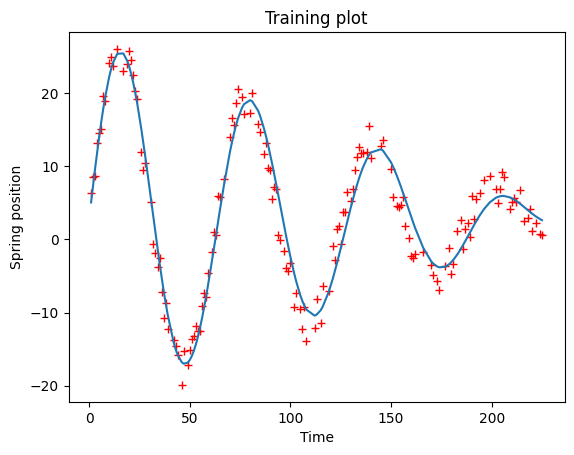

In [30]:
plt.plot(X_train11.x, y_train11, 'r+')
plt.plot(X_train11.x, yhat_train11)
plt.title("Training plot")
plt.ylabel('Spring position')
plt.xlabel('Time')

In [31]:
xx_val11 = np.array(X_val11[['bias', 'x1', 'x2']])
yy_val11 = np.array(y_val11)

yhat_val11 = predict(beta16, xx_val11)

loss_val11 = SSE(yy_val11, yhat_val11)
print("\nValidation set loss after feature engineering:")
print("SSE =", loss_val11)


Validation set loss after feature engineering:
SSE = 118.34102575154913


In [32]:
xx_test11 = np.array(X_test11[['bias', 'x1', 'x2']])
yy_test11 = np.array(y_test11)

yhat_test11 = predict(beta16, xx_test11)

loss_test11 = SSE(yy_test11, yhat_test11)
print("\nTest set loss after feature engineering:")
print("SSE =", loss_test11)


Test set loss after feature engineering:
SSE = 175.06809588504274


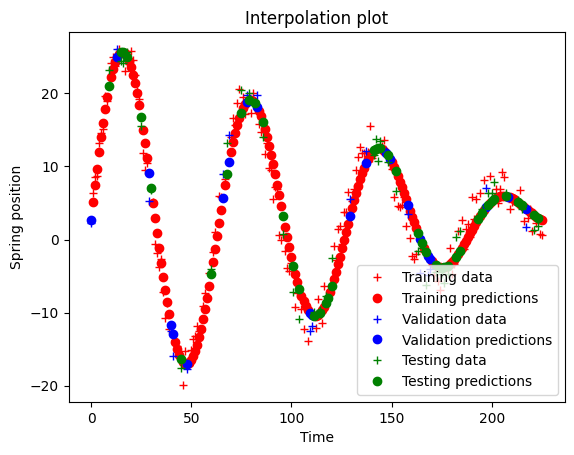

In [33]:
plt.plot(X_train11.x, y_train11, 'r+', label = 'Training data')
plt.plot(X_train11.x, yhat_train11, 'ro', label = 'Training predictions')

plt.plot(X_val11.x, y_val11, 'b+', label = 'Validation data')
plt.plot(X_val11.x, yhat_val11, 'bo', label = 'Validation predictions')

plt.plot(X_test11.x, y_test11, 'g+', label = 'Testing data')
plt.plot(X_test11.x, yhat_test11, 'go', label = 'Testing predictions')

plt.title("Interpolation plot")
plt.ylabel('Spring position')
plt.xlabel('Time')
plt.legend()

In [34]:
print("Total SSE for interpolation (Spring data) =", loss_train11 + loss_val11 + loss_test11)

Total SSE for interpolation (Spring data) = 1254.5337794616353


#### Timestamp wise spilt for extrapolation

In [35]:
X_train12 = y11.iloc[:158,:-1]
X_val12 = y11.iloc[158:180,:-1]
X_test12 = y11.iloc[180:,:-1]

y_train12 = y11.iloc[:158,-1]
y_val12 = y11.iloc[158:180,-1]
y_test12 = y11.iloc[180:, -1]

In [36]:
xx_train12 = np.array(X_train12[['bias', 'x1', 'x2']])
yy_train12 = np.array(y_train12)

beta17 = estimateBeta(xx_train12, yy_train12)

yhat_train12 = predict(beta17, xx_train12)
loss_train12 = SSE(yy_train12, yhat_train12)

print("\nSpring Position Extrapolation data")
print("\nTraining set loss after feature engineering:")
print("Beta =", beta17)
print("SSE =", loss_train12)


Spring Position Extrapolation data

Training set loss after feature engineering:
Beta = [ 2.64772879 25.15431351  1.10392523]
SSE = 883.4610459304267


Text(0.5, 0, 'Time')

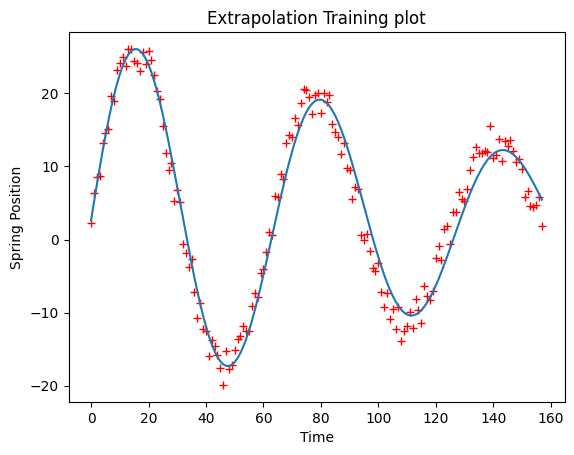

In [37]:
plt.plot(X_train12.x, y_train12, 'r+')
plt.plot(X_train12.x, yhat_train12)
plt.title("Extrapolation Training plot")
plt.ylabel('Spring Position')
plt.xlabel('Time')

In [38]:
xx_val12 = np.array(X_val12[['bias', 'x1', 'x2']])
yy_val12 = np.array(y_val12)

yhat_val12 = predict(beta17, xx_val12)

loss_val12 = SSE(yy_val12, yhat_val12)
print("\nValidation set loss after feature engineering:")
print("SSE =", loss_val12)


Validation set loss after feature engineering:
SSE = 179.29739600220339


In [39]:
xx_test12 = np.array(X_test12[['bias', 'x1', 'x2']])
yy_test12 = np.array(y_test12)

yhat_test12 = predict(beta17, xx_test12)

loss_test12 = SSE(yy_test12, yhat_test12)
print("\nTest set loss after feature engineering:")
print("SSE =", loss_test12)


Test set loss after feature engineering:
SSE = 202.98468867928776


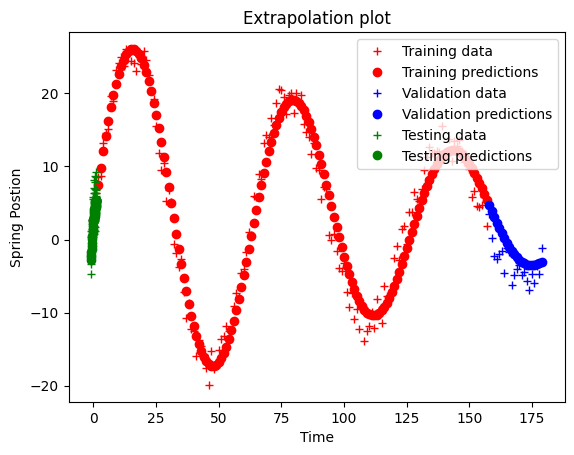

In [40]:
plt.plot(X_train12.x, y_train12, 'r+', label = 'Training data')
plt.plot(X_train12.x, yhat_train12, 'ro', label = 'Training predictions')

plt.plot(X_val12.x, y_val12, 'b+', label = 'Validation data')
plt.plot(X_val12.x, yhat_val12, 'bo', label = 'Validation predictions')

plt.plot(X_test12.x1, y_test12, 'g+', label = 'Testing data')
plt.plot(X_test12.x1, yhat_test12, 'go', label = 'Testing predictions')

plt.title("Extrapolation plot")
plt.ylabel('Spring Postion')
plt.xlabel('Time')
plt.legend()

In [41]:
print("Total SSE for extrapolation (Spring data) =", loss_train12 + loss_val12 + loss_test12)

Total SSE for extrapolation (Spring data) = 1265.7431306119179
